✓ Dependencies installed
✓ TensorFlow Version: 2.20.0
Please upload the following files:
1. best_rul_model.keras (or .h5)
2. preprocessing_data.pkl


Saving best_rul_model.keras to best_rul_model (1).keras
Saving preprocessing_data.pkl to preprocessing_data (1).pkl

✓ Files uploaded

Loading model and preprocessing data...
✓ Model loaded successfully (.keras format)
✓ Preprocessing data loaded
  Sequence length: 30
  Number of features: 26
  Features: ['Timestamp', 'SoC', 'SoH', 'Battery_Voltage', 'Battery_Current', 'Battery_Temperature', 'Charge_Cycles', 'Motor_Temperature', 'Motor_Vibration', 'Motor_Torque', 'Motor_RPM', 'Power_Consumption', 'Brake_Pad_Wear', 'Brake_Pressure', 'Reg_Brake_Efficiency', 'Tire_Pressure', 'Tire_Temperature', 'Suspension_Load', 'Ambient_Temperature', 'Ambient_Humidity', 'Load_Weight', 'Driving_Speed', 'Distance_Traveled', 'Idle_Time', 'Route_Roughness', 'Maintenance_Type']

UPLOAD NEW DATA FOR PREDICTION
Please upload your CSV file with new data
Note: CSV must have the same columns as training data


Saving Dataset.csv to Dataset (3).csv

✓ Uploaded: Dataset (3).csv

Preprocessing new data...
Original shape: (175393, 30)
✓ Data preprocessed: (175393, 26)

Creating sequences and making predictions...
✓ Sequences created: (175364, 30, 26)
✓ Predictions complete: 175364 predictions made

PREDICTION RESULTS

Prediction Statistics:
  Mean RUL: 240.88
  Median RUL: 240.88
  Min RUL: 240.88
  Max RUL: 240.88
  Std Dev: 0.00

First 20 Predictions:
 Sample_Index  Predicted_RUL
           30     240.875320
           31     240.875336
           32     240.875320
           33     240.875336
           34     240.875336
           35     240.875320
           36     240.875320
           37     240.875336
           38     240.875320
           39     240.875320
           40     240.875336
           41     240.875336
           42     240.875320
           43     240.875320
           44     240.875351
           45     240.875336
           46     240.875320
           47     240.875336
 

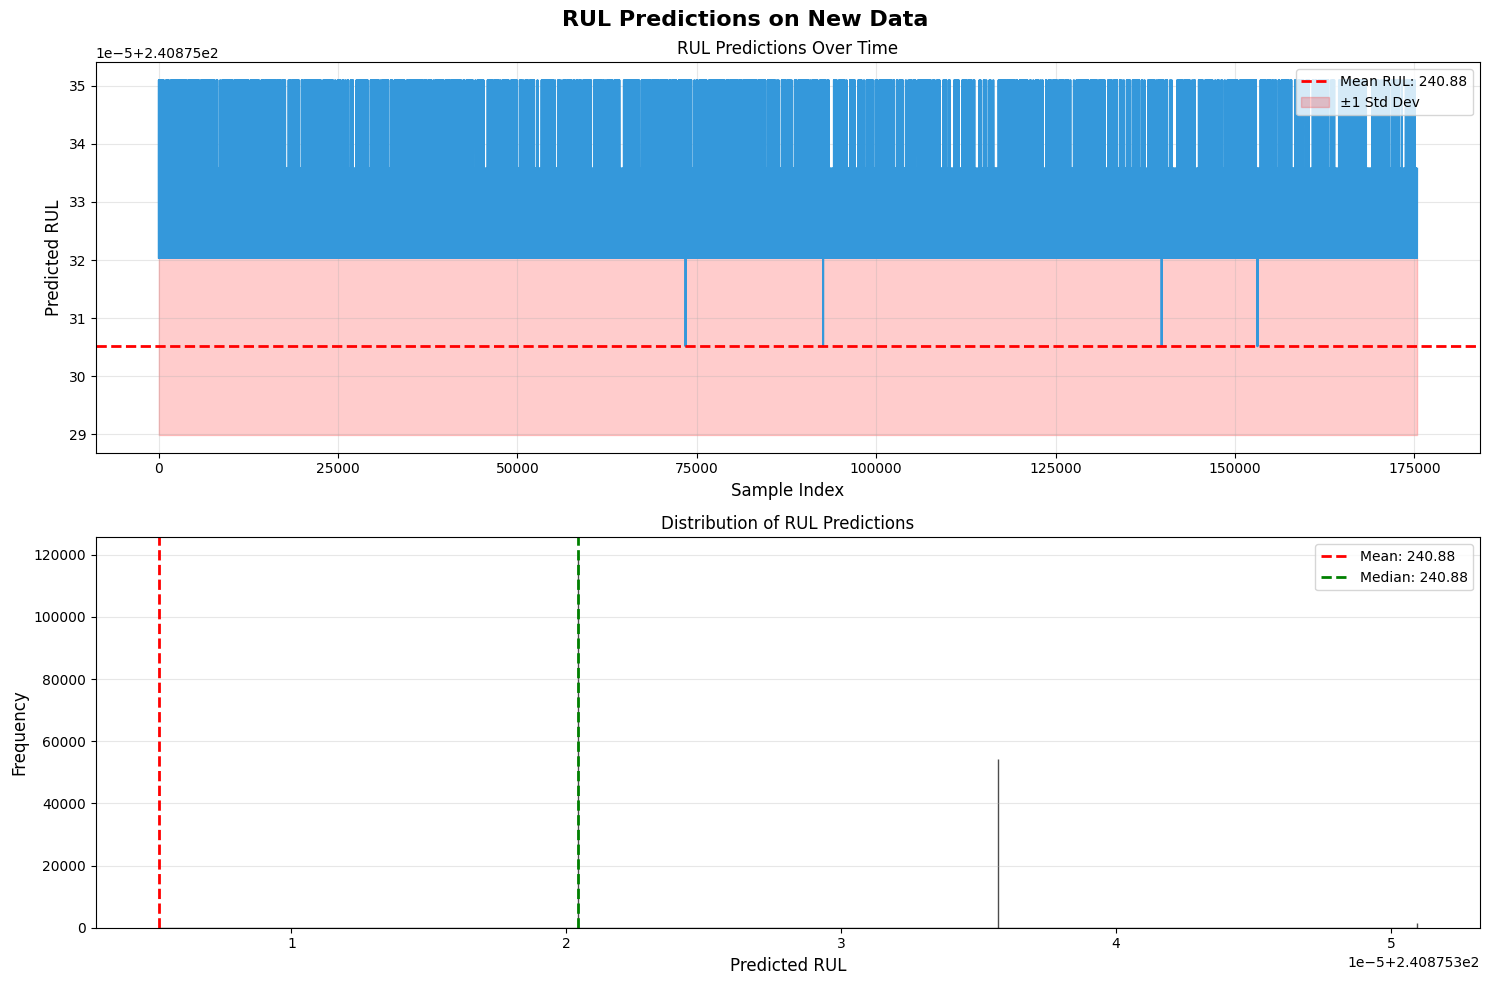

✓ Visualization saved as 'rul_predictions.png'

SAVING PREDICTIONS
✓ Predictions saved as 'rul_predictions.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Files downloaded successfully!

INFERENCE COMPLETE

SINGLE SAMPLE PREDICTION EXAMPLE

Sample Index: 100
Predicted RUL: 240.88

✓ Inference script complete!


In [6]:
# ============================================================
#   RUL INFERENCE SCRIPT
#   Load trained model and make predictions on new data
# ============================================================

# CELL 1: Install Dependencies (if needed)
# -----------------------------
!pip install matplotlib -q

print("✓ Dependencies installed")

# CELL 2: Import Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"✓ TensorFlow Version: {tf.__version__}")

# CELL 3: Upload Model and Preprocessing Files
# -----------------------------
from google.colab import files

print("Please upload the following files:")
print("1. best_rul_model.keras (or .h5)")
print("2. preprocessing_data.pkl")

uploaded = files.upload()
print("\n✓ Files uploaded")

# CELL 4: Load Model and Preprocessing Data
# -----------------------------
print("\nLoading model and preprocessing data...")

# Load the trained model (supports both .keras and .h5 formats)
try:
    model = load_model('best_rul_model.keras')
    print("✓ Model loaded successfully (.keras format)")
except:
    try:
        model = load_model('best_rul_model.h5')
        print("✓ Model loaded successfully (.h5 format)")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        raise

# Load preprocessing data
with open('preprocessing_data.pkl', 'rb') as f:
    preprocessing_data = pickle.load(f)

scaler = preprocessing_data['scaler']
feature_names = preprocessing_data['feature_names']
seq_len = preprocessing_data['seq_len']
label_encoder = preprocessing_data['label_encoder']

print(f"✓ Preprocessing data loaded")
print(f"  Sequence length: {seq_len}")
print(f"  Number of features: {len(feature_names)}")
print(f"  Features: {feature_names}")

# CELL 5: Upload New Data for Prediction
# -----------------------------
print("\n" + "="*60)
print("UPLOAD NEW DATA FOR PREDICTION")
print("="*60)
print("Please upload your CSV file with new data")
print("Note: CSV must have the same columns as training data")

new_data_uploaded = files.upload()
new_filename = list(new_data_uploaded.keys())[0]
print(f"\n✓ Uploaded: {new_filename}")

# CELL 6: Preprocess New Data
# -----------------------------
print("\nPreprocessing new data...")

# Load new data
df_new = pd.read_csv(new_filename)
print(f"Original shape: {df_new.shape}")

# Remove unwanted columns if they exist
remove_cols = ["Failure_Probability", "TTF", "Component_Health_Score", "RUL"]
for col in remove_cols:
    if col in df_new.columns:
        df_new.drop(columns=[col], inplace=True)

# Process Timestamp
if "Timestamp" in df_new.columns:
    df_new["Timestamp"] = pd.to_datetime(df_new["Timestamp"], errors='coerce')
    df_new["Timestamp"] = (df_new["Timestamp"] - df_new["Timestamp"].min()).dt.total_seconds() / 60.0

# Encode Maintenance Type
if "Maintenance_Type" in df_new.columns and label_encoder is not None:
    df_new["Maintenance_Type"] = label_encoder.transform(df_new["Maintenance_Type"].astype(str))

# Handle missing values
if df_new.isnull().sum().sum() > 0:
    df_new = df_new.ffill().bfill()

# Ensure columns match training data
missing_cols = set(feature_names) - set(df_new.columns)
if missing_cols:
    print(f"⚠ Warning: Missing columns: {missing_cols}")
    for col in missing_cols:
        df_new[col] = 0

# Reorder columns to match training
df_new = df_new[feature_names]

print(f"✓ Data preprocessed: {df_new.shape}")

# CELL 7: Create Sequences and Make Predictions
# -----------------------------
print("\nCreating sequences and making predictions...")

# Scale the data
X_new_scaled = scaler.transform(df_new)

# Create sequences
def make_sequences(data, seq_len):
    Xs = []
    for i in range(len(data) - seq_len + 1):
        Xs.append(data[i:i+seq_len])
    return np.array(Xs)

X_new_seq = make_sequences(X_new_scaled, seq_len)
print(f"✓ Sequences created: {X_new_seq.shape}")

# Make predictions
predictions = model.predict(X_new_seq, verbose=0)
predictions = predictions.flatten()

print(f"✓ Predictions complete: {len(predictions)} predictions made")

# CELL 8: Display and Save Results
# -----------------------------
print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)

# Create results dataframe
results_df = pd.DataFrame({
    'Sample_Index': range(seq_len, seq_len + len(predictions)),
    'Predicted_RUL': predictions
})

# Add statistics
print(f"\nPrediction Statistics:")
print(f"  Mean RUL: {predictions.mean():.2f}")
print(f"  Median RUL: {np.median(predictions):.2f}")
print(f"  Min RUL: {predictions.min():.2f}")
print(f"  Max RUL: {predictions.max():.2f}")
print(f"  Std Dev: {predictions.std():.2f}")

# Display first 20 predictions
print(f"\nFirst 20 Predictions:")
print(results_df.head(20).to_string(index=False))

# CELL 9: Visualize Predictions
# -----------------------------
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('RUL Predictions on New Data', fontsize=16, fontweight='bold')

# Line plot
axes[0].plot(results_df['Sample_Index'], results_df['Predicted_RUL'],
             linewidth=1.5, color='#3498db')
axes[0].axhline(y=predictions.mean(), color='r', linestyle='--',
                label=f'Mean RUL: {predictions.mean():.2f}', linewidth=2)
axes[0].fill_between(results_df['Sample_Index'],
                      predictions.mean() - predictions.std(),
                      predictions.mean() + predictions.std(),
                      alpha=0.2, color='red', label='±1 Std Dev')
axes[0].set_xlabel('Sample Index', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('RUL Predictions Over Time', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution
axes[1].hist(predictions, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].axvline(predictions.mean(), color='r', linestyle='--',
                linewidth=2, label=f'Mean: {predictions.mean():.2f}')
axes[1].axvline(np.median(predictions), color='g', linestyle='--',
                linewidth=2, label=f'Median: {np.median(predictions):.2f}')
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of RUL Predictions', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('rul_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'rul_predictions.png'")

# CELL 10: Save Predictions
# -----------------------------
print("\n" + "="*60)
print("SAVING PREDICTIONS")
print("="*60)

# Save to CSV
results_df.to_csv('rul_predictions.csv', index=False)
print("✓ Predictions saved as 'rul_predictions.csv'")

# Download the results
files.download('rul_predictions.csv')
files.download('rul_predictions.png')

print("\n✓ Files downloaded successfully!")
print("\n" + "="*60)
print("INFERENCE COMPLETE")
print("="*60)

# CELL 11: Optional - Predict for Single Sample
# -----------------------------
print("\n" + "="*60)
print("SINGLE SAMPLE PREDICTION EXAMPLE")
print("="*60)

def predict_single_sample(sample_index):
    """
    Predict RUL for a single sample

    Args:
        sample_index: Index of the sample in the new data
    """
    if sample_index < seq_len - 1:
        print(f"⚠ Warning: Need at least {seq_len} samples for prediction")
        return None

    if sample_index >= len(X_new_seq) + seq_len - 1:
        print(f"⚠ Warning: Sample index out of range")
        return None

    # Get the sequence
    seq_idx = sample_index - seq_len + 1
    sample = X_new_seq[seq_idx:seq_idx+1]

    # Predict
    pred = model.predict(sample, verbose=0)[0][0]

    print(f"\nSample Index: {sample_index}")
    print(f"Predicted RUL: {pred:.2f}")

    return pred

# Example: Predict for sample at index 100
if len(X_new_seq) > 100 - seq_len:
    predict_single_sample(100)

print("\n✓ Inference script complete!")

✓ Installation complete!
✓ TensorFlow Version: 2.20.0
✓ GPU Available: True
  Using: /physical_device:GPU:0
Please select your CSV file:


Saving Dataset.csv to Dataset (2).csv

✓ Uploaded: Dataset (2).csv

Original shape: (175393, 30)
Columns: ['Timestamp', 'SoC', 'SoH', 'Battery_Voltage', 'Battery_Current', 'Battery_Temperature', 'Charge_Cycles', 'Motor_Temperature', 'Motor_Vibration', 'Motor_Torque', 'Motor_RPM', 'Power_Consumption', 'Brake_Pad_Wear', 'Brake_Pressure', 'Reg_Brake_Efficiency', 'Tire_Pressure', 'Tire_Temperature', 'Suspension_Load', 'Ambient_Temperature', 'Ambient_Humidity', 'Load_Weight', 'Driving_Speed', 'Distance_Traveled', 'Idle_Time', 'Route_Roughness', 'RUL', 'Failure_Probability', 'Maintenance_Type', 'TTF', 'Component_Health_Score']

✓ Removed: ['Failure_Probability', 'TTF', 'Component_Health_Score']
✓ Timestamp converted to minutes
✓ Maintenance_Type encoded

✓ Final data shape: (175393, 27)
Creating sequences...
✓ Sequences created
  Input shape: (30, 26)
  Train samples: 140290
  Test samples: 35073
Defining improved models...
✓ Models defined

STARTING IMPROVED TRAINING

TRAINING: LSTM
Epoch 1

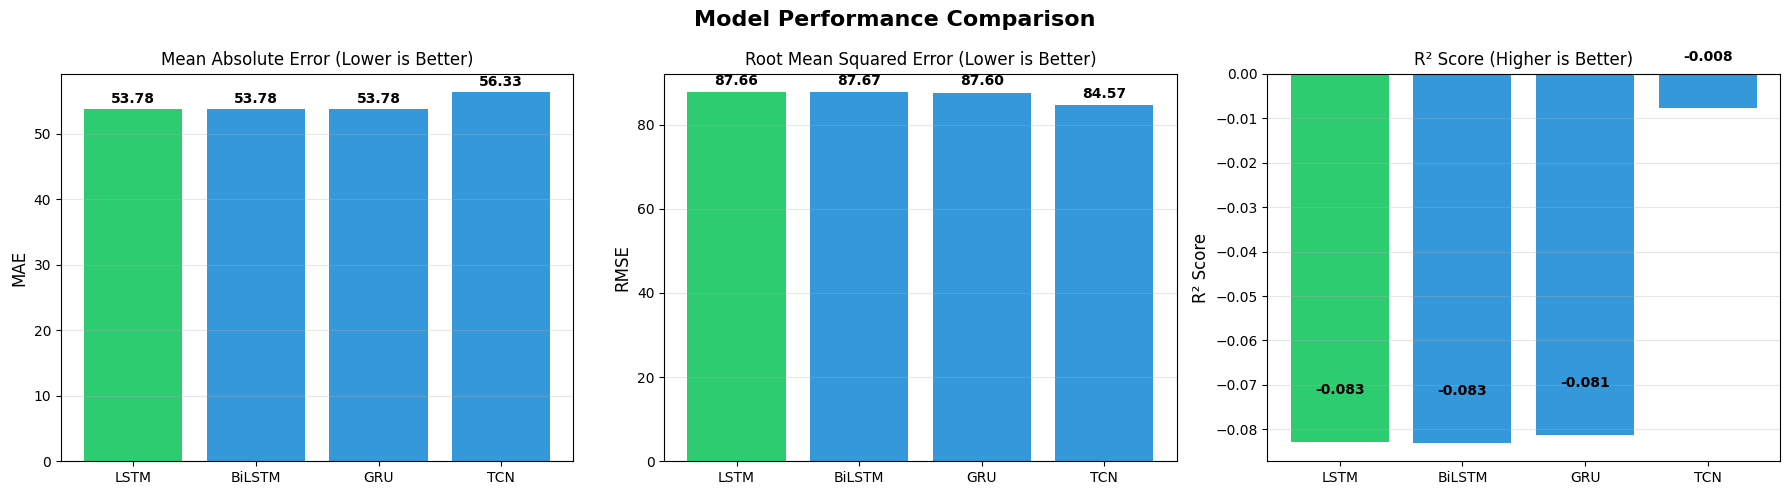

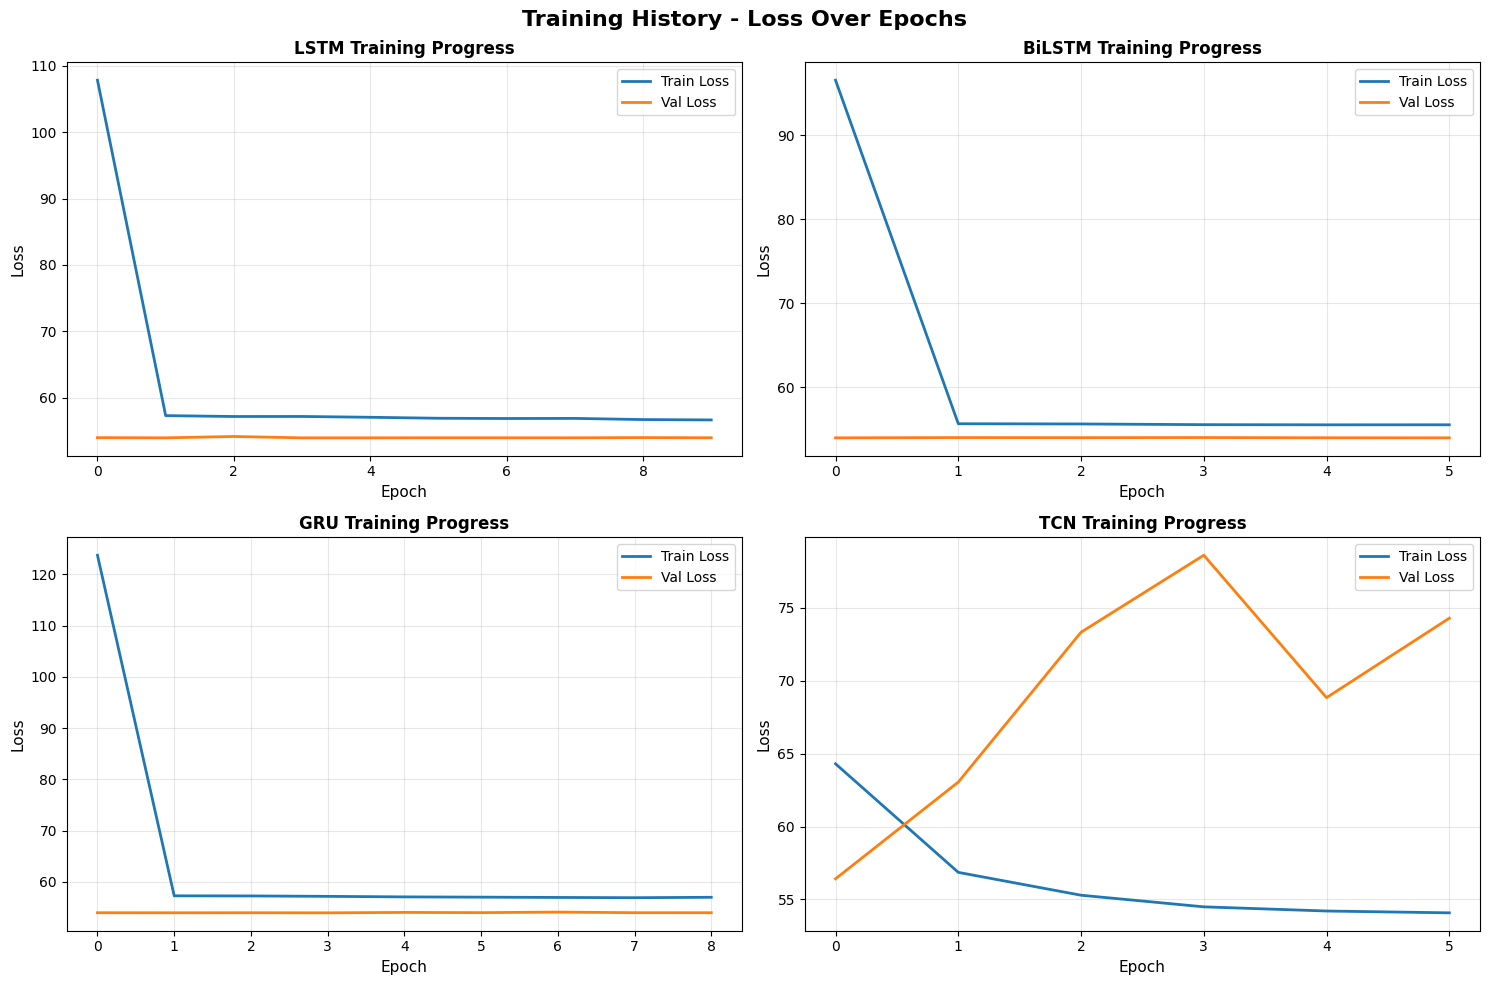

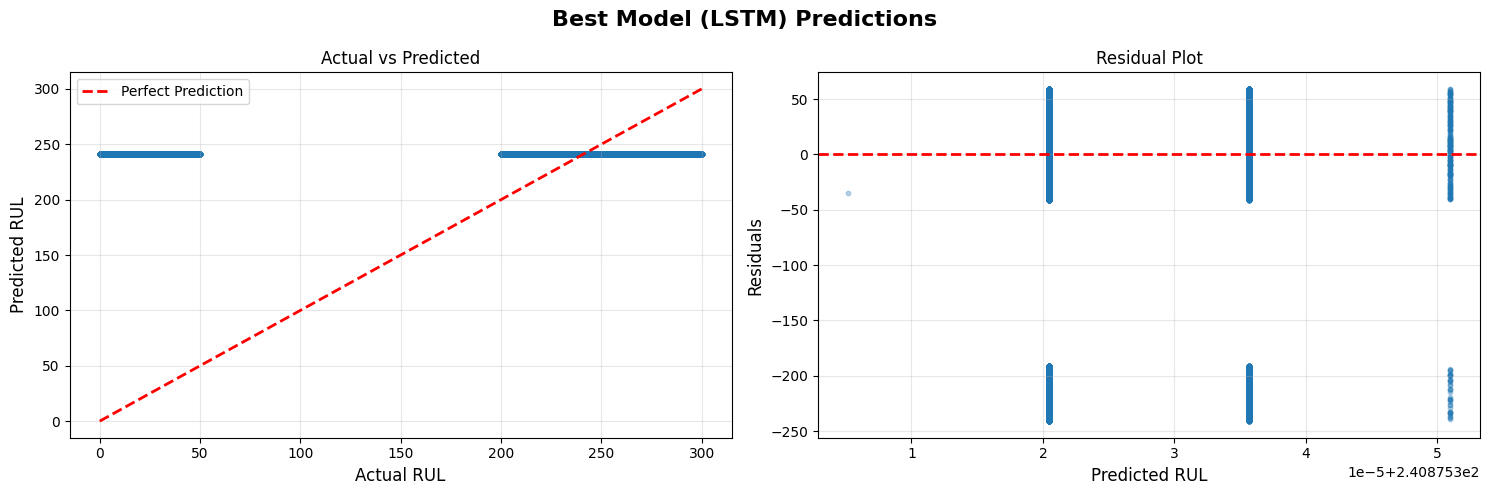

✓ Visualizations saved


                    FINAL RESULTS

Rank   Model      MAE          RMSE         R²          
----------------------------------------------------------------------
🏆      LSTM       53.7754      87.6624      -0.0828     
2      BiLSTM     53.7754      87.6715      -0.0830     
3      GRU        53.7758      87.5959      -0.0812     
4      TCN        56.3334      84.5718      -0.0078     

🏆 BEST MODEL: LSTM
   MAE: 53.7754
   RMSE: 87.6624
   R²: -0.0828

DOWNLOADING TRAINED MODELS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All files downloaded successfully!
✓ Use the inference script to make predictions on new data


In [5]:
# ============================================================
#   IMPROVED RUL PREDICTION - LSTM / BiLSTM / GRU / TCN
#   All Errors and Warnings Fixed
# ============================================================

# CELL 1: Install Dependencies
# -----------------------------
!pip install keras-tcn matplotlib seaborn -q

print("✓ Installation complete!")

# CELL 2: Import Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print(f"✓ TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"✓ GPU Available: {len(gpus) > 0}")
if gpus:
    print(f"  Using: {gpus[0].name}")

# CELL 3: Upload Your CSV File
# -----------------------------
from google.colab import files
print("Please select your CSV file:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"\n✓ Uploaded: {filename}")

# CELL 4: Load and Prepare Data
# -----------------------------
df = pd.read_csv(filename)
print(f"\nOriginal shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Remove unwanted columns
remove_cols = ["Failure_Probability", "TTF", "Component_Health_Score"]
removed = []
for col in remove_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
        removed.append(col)

if removed:
    print(f"\n✓ Removed: {removed}")

# Process Timestamp
if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
    df["Timestamp"] = (df["Timestamp"] - df["Timestamp"].min()).dt.total_seconds() / 60.0
    print("✓ Timestamp converted to minutes")

# Encode Maintenance Type
label_encoder = None
if "Maintenance_Type" in df.columns:
    label_encoder = LabelEncoder()
    df["Maintenance_Type"] = label_encoder.fit_transform(df["Maintenance_Type"].astype(str))
    print("✓ Maintenance_Type encoded")

# Handle missing values
missing = df.isnull().sum().sum()
if missing > 0:
    print(f"\n⚠ Found {missing} missing values, filling...")
    df = df.ffill().bfill()
    print("✓ Missing values filled")

print(f"\n✓ Final data shape: {df.shape}")

# CELL 5: Create Sequences
# -----------------------------
print("Creating sequences...")

y = df["RUL"].values
X = df.drop("RUL", axis=1)

# Save feature names
feature_names = X.columns.tolist()

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences
SEQ_LEN = 30

def make_sequences(data, labels, seq_len):
    Xs, ys = [], []
    for i in range(len(data) - seq_len):
        Xs.append(data[i:i+seq_len])
        ys.append(labels[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_scaled, y, SEQ_LEN)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

input_shape = (X_train.shape[1], X_train.shape[2])

print(f"✓ Sequences created")
print(f"  Input shape: {input_shape}")
print(f"  Train samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")

# CELL 6: Define Improved Models
# -----------------------------
print("Defining improved models...")

def build_lstm(shape):
    model = Sequential([
        Input(shape=shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="huber", metrics=["mae", "mse"])
    return model

def build_bilstm(shape):
    model = Sequential([
        Input(shape=shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="huber", metrics=["mae", "mse"])
    return model

def build_gru(shape):
    model = Sequential([
        Input(shape=shape),
        GRU(128, return_sequences=True),
        Dropout(0.3),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="huber", metrics=["mae", "mse"])
    return model

def residual_block(x, dilation_rate, nb_filters, kernel_size, dropout_rate):
    """Custom residual block to replace TCN"""
    prev_x = x

    # First conv layer
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Second conv layer
    x = Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Residual connection
    if prev_x.shape[-1] != nb_filters:
        prev_x = Conv1D(filters=nb_filters, kernel_size=1, padding='same')(prev_x)

    x = Add()([prev_x, x])
    x = Activation('relu')(x)

    return x

def build_tcn(shape):
    """Build TCN-like model using custom residual blocks"""
    inputs = Input(shape=shape)
    x = inputs

    # Stack of residual blocks with increasing dilation
    dilations = [1, 2, 4, 8, 16]
    for dilation in dilations:
        x = residual_block(x, dilation, 128, 3, 0.3)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="huber", metrics=["mae", "mse"])
    return model

print("✓ Models defined")

# CELL 7: Train All Models
# -----------------------------
print("\n" + "="*60)
print("STARTING IMPROVED TRAINING")
print("="*60)

models = {
    "LSTM": build_lstm(input_shape),
    "BiLSTM": build_bilstm(input_shape),
    "GRU": build_gru(input_shape),
    "TCN": build_tcn(input_shape)
}

results = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"TRAINING: {name}")
    print('='*60)

    # Improved callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=0
    )

    checkpoint = ModelCheckpoint(
        f'{name}_best.keras',  # Use .keras format
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=2  # Less verbose output
    )

    # Evaluate
    loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[name] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'loss': loss
    }

    histories[name] = history.history

    print(f"\n✓ {name} Complete")
    print(f"  Test MAE: {mae:.4f}")
    print(f"  Test RMSE: {rmse:.4f}")
    print(f"  Test R²: {r2:.4f}")

# CELL 8: Save Best Model and Components
# -----------------------------
print("\n" + "="*60)
print("SAVING BEST MODEL")
print("="*60)

# Find best model
best_model_name = min(results.items(), key=lambda x: x[1]['mae'])[0]
best_model = models[best_model_name]

# Save model in native Keras format
best_model.save('best_rul_model.keras')
print(f"✓ Best model ({best_model_name}) saved as 'best_rul_model.keras'")

# Save preprocessing components
preprocessing_data = {
    'scaler': scaler,
    'feature_names': feature_names,
    'seq_len': SEQ_LEN,
    'label_encoder': label_encoder
}

with open('preprocessing_data.pkl', 'wb') as f:
    pickle.dump(preprocessing_data, f)

print("✓ Preprocessing data saved as 'preprocessing_data.pkl'")

# Save results
with open('training_results.pkl', 'wb') as f:
    pickle.dump({'results': results, 'histories': histories}, f)

print("✓ Training results saved as 'training_results.pkl'")

# CELL 9: Visualize Results
# -----------------------------
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# 1. Model Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

sorted_models = sorted(results.items(), key=lambda x: x[1]['mae'])
model_names = [m[0] for m in sorted_models]
maes = [m[1]['mae'] for m in sorted_models]
rmses = [m[1]['rmse'] for m in sorted_models]
r2s = [m[1]['r2'] for m in sorted_models]

colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(model_names))]

axes[0].bar(model_names, maes, color=colors)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error (Lower is Better)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(maes):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

axes[1].bar(model_names, rmses, color=colors)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmses):
    axes[1].text(i, v + 1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

axes[2].bar(model_names, r2s, color=colors)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Higher is Better)', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2s):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Training History
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History - Loss Over Epochs', fontsize=16, fontweight='bold')

for idx, (name, history) in enumerate(histories.items()):
    ax = axes[idx // 2, idx % 2]
    ax.plot(history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title(f'{name} Training Progress', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Best Model Predictions
y_pred_best = best_model.predict(X_test, verbose=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'Best Model ({best_model_name}) Predictions', fontsize=16, fontweight='bold')

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual RUL', fontsize=12)
axes[0].set_ylabel('Predicted RUL', fontsize=12)
axes[0].set_title('Actual vs Predicted', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residual plot
residuals = y_test - y_pred_best.flatten()
axes[1].scatter(y_pred_best, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted RUL', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=12)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved")

# CELL 10: Final Results Table
# -----------------------------
print("\n\n" + "="*70)
print(" "*20 + "FINAL RESULTS")
print("="*70)

sorted_results = sorted(results.items(), key=lambda x: x[1]['mae'])

print(f"\n{'Rank':<6} {'Model':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
print("-" * 70)

for rank, (name, metrics) in enumerate(sorted_results, 1):
    marker = "🏆" if rank == 1 else f"{rank}"
    print(f"{marker:<6} {name:<10} {metrics['mae']:<12.4f} {metrics['rmse']:<12.4f} {metrics['r2']:<12.4f}")

best_mae = sorted_results[0][1]['mae']

print("\n" + "="*70)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   MAE: {best_mae:.4f}")
print(f"   RMSE: {sorted_results[0][1]['rmse']:.4f}")
print(f"   R²: {sorted_results[0][1]['r2']:.4f}")
print("="*70)

# Download files
print("\n" + "="*70)
print("DOWNLOADING TRAINED MODELS")
print("="*70)

files.download('best_rul_model.keras')
files.download('preprocessing_data.pkl')
files.download('training_results.pkl')
files.download('model_comparison.png')
files.download('training_history.png')
files.download('best_model_predictions.png')

print("\n✓ All files downloaded successfully!")
print("✓ Use the inference script to make predictions on new data")